In [191]:
import lightgbm as lgb
import pandas as pd
import datetime
import numpy as np



%cd C:\Users\user\Desktop\Git\Lightgbm

data = pd.read_csv('med_close.csv') # reading all the data from part 1 from med_close.csv

# define some utility functions here
def subtract_month(datetime_object,number_of_month_to_be_subtracted):
    date=datetime_object.day
    month=datetime_object.month
    year=datetime_object.year

    new_month=month-number_of_month_to_be_subtracted
    
    if new_month<=0:
        year=year-1
        new_month=12+new_month
    
    return datetime.datetime(year,new_month,date)

def add_month(datetime_object,number_of_month_to_be_added):
    date=datetime_object.day
    month=datetime_object.month
    year=datetime_object.year

    new_month=month+number_of_month_to_be_added
    
    if new_month>12:
        year=year+1
        new_month=new_month-12
    
    return datetime.datetime(year,new_month,date)

C:\Users\user\Desktop\Git\Lightgbm


In [163]:
# Define some variables for later use

past_1_month_data_2020=None # training data
path_3_month_data_2020=None # training data
path_1_year_data_2020=None # training data
label=None # label

validation_1_month_2021=None # validation set
validation_3_month_2021=None # validation set
validation_1_year_2021=None # validation set

In [164]:
# Get the Boolean indexing for training data

# Split Month column by delimiter '-' for separating year, month and day
splitted_column_by_year_month_date=data['Month'].str.split('-', expand=True) 
splitted_column_by_year_month_date

# get the boolean array for months between 2019 and 2022
boolean_2019_to_2022 = ((splitted_column_by_year_month_date[0]== '2020')|(splitted_column_by_year_month_date[0]== '2019') | (splitted_column_by_year_month_date[0]== '2021') |(splitted_column_by_year_month_date[0]== '2022'))
date_2019_to_2022 = data.loc[boolean_2019_to_2022]

In [169]:
# Preparing training data for year 2020
# We assume that return is the difference between med_close of different months!

tickers = date_2019_to_2022['Ticker'].unique() # get a list of tickers

Ticker=[]
past_one_month_data_2020=[]
past_three_month_data_2020=[]
past_one_year_data_2020=[]
label_train=[]

month_of_2020=[datetime.datetime(2020,i,1) for i in range(1,13)] # generating a list of month(datetime object), e.g. '2020-01-01'
month_of_2021=[datetime.datetime(2021,i,1) for i in range(1,13)]





for ticker in tickers:
    for month in month_of_2020:
        
        Ticker.append(ticker.split('.')[0])   
        
        # getting the return by calculating the difference between med_close of this month and last month
        retrn_one_month = date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==month.strftime('%Y-%m-%d'))]['Median'].iloc[0] 
        -  date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==subtract_month(month,1).strftime('%Y-%m-%d'))]['Median'].iloc[0]
        past_one_month_data_2020.append(retrn_one_month)
        
        # getting the return by calculating the difference between med_close of this month and 3 months ago
        retrn_three_month = date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==month.strftime('%Y-%m-%d'))]['Median'].iloc[0] -  date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==subtract_month(month,3).strftime('%Y-%m-%d'))]['Median'].iloc[0]
        past_three_month_data_2020.append(retrn_three_month)
        
        # getting the return by calculating the difference between med_close of this month and 1 year ago
        retrn_one_year = date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==month.strftime('%Y-%m-%d'))]['Median'].iloc[0] -  date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==subtract_month(month,12).strftime('%Y-%m-%d'))]['Median'].iloc[0]
        past_one_year_data_2020.append(retrn_one_year)

        # label is the med_close of next month
        retrn_label = date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==add_month(month,1).strftime('%Y-%m-%d'))]['Median'].iloc[0]
        label_train.append(retrn_label)

training_data=pd.DataFrame({
    'Ticker':Ticker,
    'past_one_month_data_2020':past_one_month_data_2020,   
    'past_three_month_data_2020':past_three_month_data_2020,
    'past_one_year_data_2020':past_one_year_data_2020,
    'label_train':label_train
    })

training_data.to_csv('training_data.csv') # save training data to csv

In [170]:
# Model building by fitting the training data

model = lgb.LGBMRegressor() # Building a lgb Regressor object
data=pd.read_csv('training_data.csv') # Read the training data from year 2020
ticker=data['Ticker'].to_numpy() 
past_one_month_data_2020=data['past_one_month_data_2020'].to_numpy().astype(float) # converting return to floats
past_three_month_data_2020=data['past_three_month_data_2020'].to_numpy().astype(float)
past_one_year_data_2020=data['past_one_year_data_2020'].to_numpy().astype(float)
label_train=data['label_train'].to_numpy().astype(int) # converting ticker number to integer

features = list(zip(ticker,past_one_month_data_2020, past_three_month_data_2020,past_one_year_data_2020))# Combine all the features into single list of tuples

model.fit(features, label_train) # train the lgb model

LGBMRegressor()

In [180]:
# Preparing validation data for year 2021

tickers = date_2019_to_2022['Ticker'].unique() # get a list of tickers
month_of_2021=[datetime.datetime(2021,i,1) for i in range(1,9)]# generating a list of month(datetime object), e.g. '2020-01-01', excluding Oct-Dec, 2021 (there is no 2022-Jan for label)

Ticker=[]
past_one_month_data_2021=[]
past_three_month_data_2021=[]
past_one_year_data_2021=[]
label_test=[]

for ticker in tickers:
    for month in month_of_2021:
        
        Ticker.append(ticker.split('.')[0])   
        
        # getting the return by calculating the difference between med_close of this month and last month
        retrn_one_month = date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==month.strftime('%Y-%m-%d'))]['Median'].iloc[0] 
        -  date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==subtract_month(month,1).strftime('%Y-%m-%d'))]['Median'].iloc[0]
        past_one_month_data_2021.append(retrn_one_month)
        
        # getting the return by calculating the difference between med_close of this month and 3 months ago
        retrn_three_month = date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==month.strftime('%Y-%m-%d'))]['Median'].iloc[0] -  date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==subtract_month(month,3).strftime('%Y-%m-%d'))]['Median'].iloc[0]
        past_three_month_data_2021.append(retrn_three_month)
        
        # getting the return by calculating the difference between med_close of this month and 1 year ago
        retrn_one_year = date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==month.strftime('%Y-%m-%d'))]['Median'].iloc[0] -  date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==subtract_month(month,12).strftime('%Y-%m-%d'))]['Median'].iloc[0]
        past_one_year_data_2021.append(retrn_one_year)

        # label is the med_close of next month
        retrn_label = date_2019_to_2022.loc[(date_2019_to_2022['Ticker']==ticker) & (date_2019_to_2022['Month']==add_month(month,1).strftime('%Y-%m-%d'))]['Median'].iloc[0]
        label_test.append(retrn_label)

testing_data=pd.DataFrame({
    'Ticker':Ticker,
    'past_one_month_data_2021':past_one_month_data_2021,   
    'past_three_month_data_2021':past_three_month_data_2021,
    'past_one_year_data_2021':past_one_year_data_2021,
    'label_test':label_test
    })

testing_data.to_csv('testing_data.csv') 

In [181]:
# Load testing_data and get model accuracy score
data=pd.read_csv('testing_data.csv') # Read the testing data from year 2021

ticker=data['Ticker'].to_numpy() 
past_one_month_data_2021=data['past_one_month_data_2021'].to_numpy().astype(float) # converting return to floats
past_three_month_data_2021=data['past_three_month_data_2021'].to_numpy().astype(float)
past_one_year_data_2021=data['past_one_year_data_2021'].to_numpy().astype(float)
label_test=data['label_test'].to_numpy().astype(int) # converting ticker number to integer

features = list(zip(ticker,past_one_month_data_2021, past_three_month_data_2021,past_one_year_data_2021))

score=model.score(features,label_test)
print('The accuracy score is: ' +str(score))

The accuracy score is: 0.8445201964118451


In [188]:
# Getting the most important features

feature_importance=np.array(model.feature_importances_)
feature_name=np.array(model.feature_name_)

<AxesSubplot:xlabel='Feature name'>

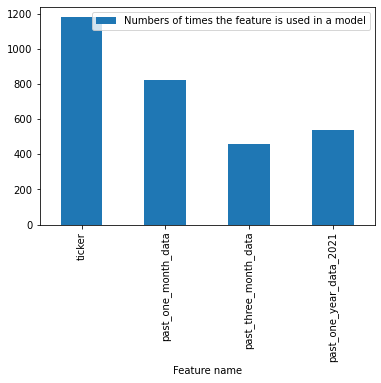

In [195]:
# Plotting the most important features

df = pd.DataFrame({'Numbers of times the feature is used in a model': feature_importance,
                   'Feature name': ['ticker', 'past_one_month_data', 'past_three_month_data', 'past_one_year_data_2021']})
df.plot(x ='Feature name', y='Numbers of times the feature is used in a model', kind = 'bar')